In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import pearsonr


In [5]:
# Set up files
# includes N = 9 from the most recent data collection (last time the last block had repeated words,
# now all words appear only once)
# Set up files
dir_noQuestion = 'pilot_multiple_repeats_data/rsvpFourBlocksData/secondRun_fourBlocks_noRepeatedWords'
files_noQuestion = [f for f in os.listdir(dir_noQuestion) if f.endswith('.csv')]

dir_effortQ = 'pilot_multiple_repeats_data/rsvpFourBlocksData/thirdRun_effortQ'
files_effortQ = [f for f in os.listdir(dir_effortQ) if f.endswith('.csv')]


numTotalSubj = len(files_noQuestion) + len(files_effortQ)

print('Number of subjects: ', numTotalSubj)

Number of subjects:  19


In [6]:
def getThresholds(mydir, files, block_end, question_blocks_bool, numRepeats = 4, block_start = 2, 
                     num_staircase_per_block = 1, num_trials_per_staircase = 24):
    
    # initialize data matrix
    numSubj = len(files)
    
    subj_thresholds = np.full((numSubj, numRepeats), np.nan)

    
    # calculate thresholds
    for subj in range(numSubj):

        # Read the CSV file
        file_path = os.path.join(mydir, files[subj])
        mainOutput = pd.read_csv(file_path)

        # Exclusion criteria 1: experiment completed
        complete_val = mainOutput['experimentCompleteBool'].dropna().iloc[0]
        complete_bool = str(complete_val) == 'True'
        if not complete_bool:
            print(f'Warning: incomplete experiment (Subject {subj+1}, Block {b-1}, staircase {s})')

        if question_blocks_bool:
            blocks_include = range(block_start, block_end, 2)
        else:
            blocks_include = range(block_start, block_end + 1)
            
        for b in blocks_include:  # Loop over blocks
                
            for s in range(num_staircase_per_block):  # Loop over staircases

                blockOfInterest = b
                staircase = s + 1
                staircase_name = f'{blockOfInterest}_{staircase}'

                # Filter rows based on block and staircase
                rows_staircase = mainOutput[mainOutput['staircaseName'] == staircase_name]

                # Exclusion criteria 2: number of trials sent to quest
                # Count trials sent to quest
                trial_sent = rows_staircase['trialGivenToQuest']
                num_trial_sent = sum(str(this_trial) == 'True' for this_trial in trial_sent)
                trial_sent_bool = num_trial_sent >= num_trials_per_staircase
                if not trial_sent_bool:
                    print(f'Warning: not enough trials (Subject {subj+1}, Block {b}, staircase {s})')


                # Exclusion criteria 3: questSD > 0.1
                questSD = rows_staircase['questSDAtEndOfTrialsLoop'].dropna().iloc[0]
                small_questSD_bool = questSD < 0.1
                if not small_questSD_bool:
                    print(f'Warning: large SD (Subject {subj+1}, Block {b}, staircase {s})')


                # Process thresholds
                if complete_bool and trial_sent_bool and small_questSD_bool:
                    thresholds_raw = rows_staircase['questMeanAtEndOfTrialsLoop'].dropna().values
                    assert len(thresholds_raw) == 1, 'Error: more than 1 thresholds'

                    thresholds_raw_log = thresholds_raw[0]

                    thresholds_raw_wpm = np.power(10, np.log10(60) - thresholds_raw_log)


                    # Assign threshold
                    if question_blocks_bool:
                        subj_thresholds[subj, b//2 - 1] = thresholds_raw_wpm

                    else:
                        subj_thresholds[subj, b - 2] = thresholds_raw_wpm
                else:
                    if question_blocks_bool:
                        subj_thresholds[subj, b//2 - 1] = np.nan

                    else:
                        subj_thresholds[subj, b - 2] = np.nan                  
                    
                        
                        
    return subj_thresholds
                        



In [7]:
numRepeats = 4
block_start = 2                            # excluding the first block
block_end = block_start + numRepeats - 1 

subj_thresholds1 = getThresholds(dir_noQuestion, files_noQuestion, block_end, False)

In [8]:
block_end = block_start + 2 * numRepeats - 1 

subj_thresholds2 = getThresholds(dir_effortQ, files_effortQ, block_end, True)

subj_thresholds2 = np.delete(subj_thresholds2, [6, 7], axis=0)


In [9]:
subj_thresholds = np.vstack((subj_thresholds1, subj_thresholds2))

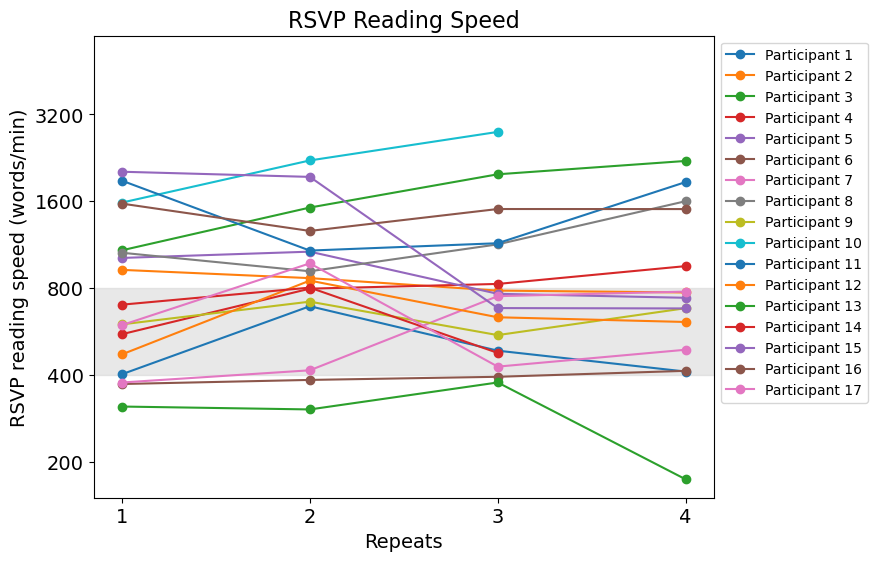

In [10]:
import matplotlib.ticker as mticker
# Plot 
repeats = np.arange(1, subj_thresholds.shape[1] + 1)

plt.figure(figsize=(8, 6))

ymin = (600 - 200)
ymax = (600 + 200)
plt.axhspan(ymin, ymax, color='lightgray', alpha=0.5)

for i, row in enumerate(subj_thresholds):
    plt.plot(repeats, row, marker='o', label=f'Participant {i+1}')
plt.title('RSVP Reading Speed', fontsize = 16)
plt.xlabel('Repeats', fontsize = 14)
plt.xticks([1,2,3,4])
plt.ylabel('RSVP reading speed (words/min)', fontsize = 14)
plt.ylim([150,6000])
plt.legend()
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.yticks([200, 400, 800, 1600, 3200],label = [200, 400, 800, 1600, 3200])
plt.gca().tick_params(labelsize=14)
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False)) 
plt.gca().yaxis.set_minor_locator(plt.NullLocator())

plt.show()


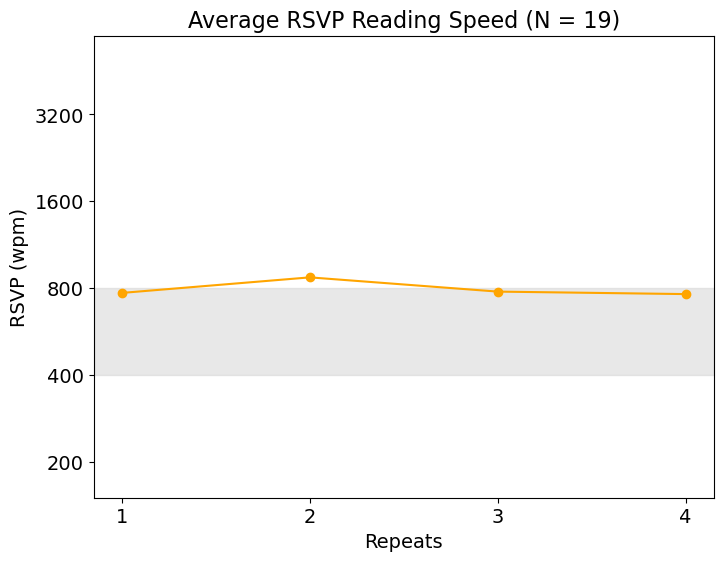

In [11]:
plt.figure(figsize=(8, 6))
patch_min = 600 - 200
patch_max = 600 + 200
plt.axhspan(patch_min, patch_max, color='lightgray', alpha=0.5)
plt.plot(range(1,5), 10 ** np.nanmean(np.log10(subj_thresholds), axis = 0), marker='o', color = 'orange')
plt.title(f'Average RSVP Reading Speed (N = {numTotalSubj})', fontsize = 16)
plt.xlabel('Repeats', fontsize = 14)
plt.xticks(range(1,5))
plt.ylabel('RSVP (wpm)', fontsize = 14)
plt.yscale('log')
plt.yticks([200, 400, 800, 1600, 3200],label = [200, 400, 800, 1600, 3200])
plt.gca().tick_params(labelsize=14)
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False)) 
plt.gca().yaxis.set_minor_locator(plt.NullLocator())
plt.ylim([150,6000])

plt.show()

In [12]:
print(np.nanmean(np.log10(subj_thresholds), axis = 0))

[2.88632681 2.94021464 2.89084567 2.88221423]


In [13]:
# take the log of the thresholds
subj_wpm_log = np.log10(subj_thresholds)
print(subj_wpm_log)

[[2.60436208 2.84012431 2.6860049  2.6136152 ]
 [2.96621889 2.93754714 2.89432413 2.88784675]
 [3.03407664 3.18234042 3.29765444 3.34389425]
 [2.7431746  2.9011236  2.91740468 2.97917043]
 [3.00760278 3.0293614  2.88314425 2.86937791]
 [2.57042564 2.58458713 2.59544489 2.61607135]
 [2.57562997 2.61795218 2.875051   2.89078716]
 [3.02555407 2.9613382  3.05466529 3.20428426]
 [2.77726042 2.8559888  2.74001392 2.83330937]
 [3.19952325 3.34565695 3.44459955        nan]
 [3.27549169 3.03311046 3.05859534 3.27062113]
 [2.67320623 2.92901036 2.80181749 2.78551707]
 [2.49227528 2.48223593 2.57572    2.24000333]
 [2.84554346 2.90463778 2.67829626        nan]
 [3.30651154 3.28862708 2.83371985 2.83247037]
 [3.19594315 3.10121848 3.17720973 3.17703861]
 [2.77475614 2.98878867 2.63071074 2.68920632]]


In [14]:
def calculate_within_btw_std(subj_thresholds):

    within_individual_std = np.nanmean(np.nanvar(subj_thresholds, axis=1, ddof=1))

    across_individuals_std = np.nanvar(np.nanmean(subj_thresholds, axis=1), ddof=1)

    # 3. Total Variance: Variance across all participants and all runs
    #total_std = np.log(np.std(subj_thresholds, ddof=1))

    return within_individual_std, across_individuals_std

def calculate_btw_within_ratio(btw, within):
    '''
    Input: btw and within individual std IN LOG UNITS
    '''
    assert(btw.shape == within.shape)
    
    ratio = (10**btw)/(10**within)
    
    return ratio

In [15]:
within_forward = np.full((numRepeats-1,1),np.nan)
btw_forward = np.full((numRepeats-1,1),np.nan)


for ii in range(2, numRepeats+1):

    filtered_data = subj_wpm_log[:,:ii]
        
    within_forward[ii-2], btw_forward[ii-2] = calculate_within_btw_std(filtered_data)
    
    
print(within_forward)
print(btw_forward)

[[0.00942229]
 [0.01489904]
 [0.0157162 ]]
[[0.05692518]
 [0.05138278]
 [0.05576721]]


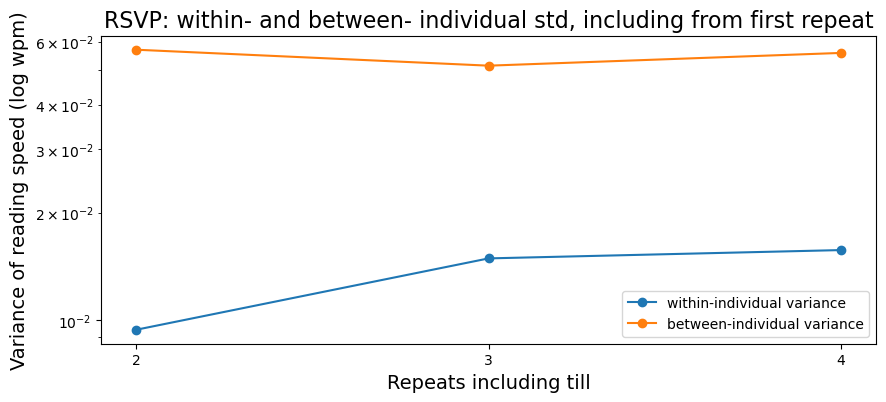

In [16]:
# Plot 
repeats = range(2, numRepeats+1)

plt.figure(figsize=(10, 4))
plt.plot(repeats, within_forward, marker='o', label='within-individual variance')
plt.plot(repeats, btw_forward, marker='o', label='between-individual variance')

plt.title('RSVP: within- and between- individual std, including from first repeat', fontsize = 16)
plt.xlabel('Repeats including till', fontsize = 14)
plt.xticks(repeats)
plt.ylabel('Variance of reading speed (log wpm)', fontsize = 14)
plt.legend()
plt.yscale('log')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.gca().tick_params(labelsize=14)
plt.show()



In [17]:
within_backwards = np.full((numRepeats-1,1),np.nan)
btw_backwards = np.full((numRepeats-1,1),np.nan)


for ii in range(0, numRepeats-1):

    filtered_data = subj_wpm_log[:,ii:]
        
    within_backwards[ii], btw_backwards[ii] = calculate_within_btw_std(filtered_data)
    

/var/folders/sk/b_2c8s2n1g1285l9s6dhhql80000gn/T/ipykernel_94953/11739595.py:3: RuntimeWarning: Degrees of freedom <= 0 for slice.
  within_individual_std = np.nanmean(np.nanvar(subj_thresholds, axis=1, ddof=1))


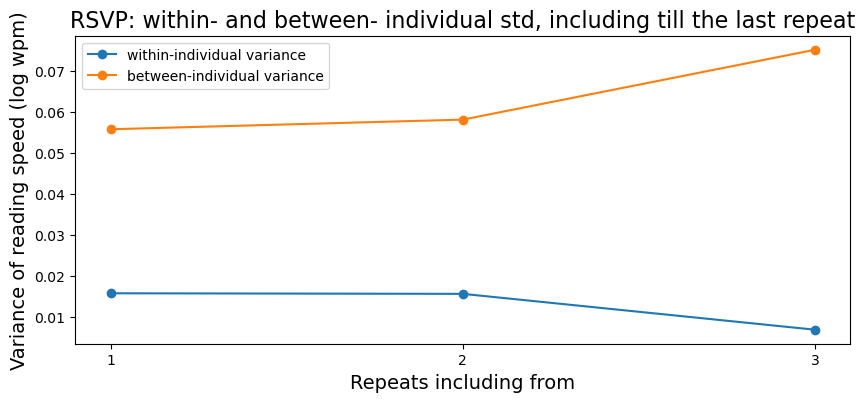

In [18]:
# Plot
repeats = range(1, numRepeats)

plt.figure(figsize=(10, 4))
plt.plot(repeats, within_backwards, marker='o', label='within-individual variance')
plt.plot(repeats, btw_backwards, marker='o', label='between-individual variance')

plt.title('RSVP: within- and between- individual std, including till the last repeat', fontsize = 16)
plt.xlabel('Repeats including from', fontsize = 14)
plt.xticks(repeats)
plt.ylabel('Variance of reading speed (log wpm)', fontsize = 14)
plt.legend()
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.gca().tick_params(labelsize=14)
plt.show()


In [19]:
def plot_test_retest_scatter(data, group_X, group_Y):
    '''
    This function filters the data given the provided groupings and plots a scatter plot of test vs. retest
    It can give us an intuition of the within- and between- individual variances
    (i.e., if the within-std is large relative to the btw-std, R is low, and vice versa)
    
    Inputs:
    subj_data:        thresholds for each repeat of each individual. 
                      2D matrix with rows as individuals and columns as repeats.
    group_X, group_Y: specify which repeat(s) (i.e., columns) to include when averaging and plotting
                      for each dimension (X and Y).
                      These two arrays are lists but not np arrays.
    '''
    
    # filter data given the provided groupings
    group_X_array = np.array(group_X)
    group_Y_array = np.array(group_Y)

    data_X = data[:, group_X_array - 1]
    data_Y = data[:, group_Y_array - 1]
    
    
    # calculate one mean for each subject
    means_X = np.nanmean(data_X, axis = 1)
    means_Y = np.nanmean(data_Y, axis = 1)
    
    r_value, _ = pearsonr(means_X, means_Y)
    

    # Create scatter plot
    plt.figure(figsize=(4, 4))  # Make the plot square
    plt.scatter(10 ** means_X, 10 ** means_Y, color='purple', alpha = 0.7)
    plt.plot([200, 3000], [200, 3000], color='red', linestyle='--', label='y = x')  # Line y = x

    # Set axes to have equal scale
    plt.axis('equal')
    plt.xscale('log')
    plt.yscale('log')

    # add ticks and format them as normal floats
    tick_positions = [200, 400, 1000, 2000, 3000]
    plt.xticks(tick_positions, labels=[f"{x:.0f}" for x in tick_positions], fontsize = 12)
    plt.yticks(tick_positions, labels=[f"{x:.0f}" for x in tick_positions], fontsize = 12)

    # Add labels and legend
    plt.xlabel(f'Average over repeats {group_X}', fontsize = 14)
    plt.ylabel(f'Average over repeats {group_Y}', fontsize = 14)
    plt.title(f'Test vs. Retest Correlation (R = {round(r_value,2)})', fontsize = 16)

    # Show the plot
    plt.show()


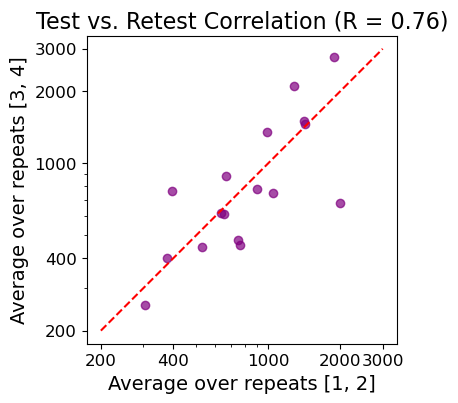

In [20]:
plot_test_retest_scatter(np.log10(subj_thresholds), [1,2], [3,4])


## Save unlogged data

In [21]:
def save_mtx_as_df(matrix, file_path, matrix_name):
    '''
    This function takes in a matrix and its path, and saves it as a data frame in a csv.
    It allows you to customize the name of the file being saved and the folder in which it will be saved.
    
    inputs:
    - matrix: the matrix you're saving
    - file_path: has to be a string: the path to the folder you want the csv to be in
    - matrix_name: has to be a string: the name of the csv file
    '''

    df = pd.DataFrame(matrix)
    file_name = file_path + matrix_name
    df.to_csv(file_name, index=False)

In [23]:
file_path = 'pilot_multiple_repeats_data/thresholds_clean/'
save_mtx_as_df(subj_thresholds, file_path, 'df_RSVP.csv')